# <span style="color:cornflowerblue"><center> Numerical Simulation Laboratory</center></span>
## <span style="color:cornflowerblue"><center> Samuele Brambilla - Notebook 7</center></span>

### Exercise 07.1
In the MD/MC code we have provided, include tail corrections for potential energy, $U$, and pressure $P$.

### Exercise 07.2

Use the MD/MC code to print out instantaneous values of potential energy per particle, $U/N$, along **equilibrated** Monte Carlo simulations (of $M=5\times 10^5$ MC steps and where the Metropolis acceptance ratio has been fixed approximately to 50%) in the following thermodynamic conditions:
- solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
- liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
- gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

1. Once this data has been produced, compute and make pictures with a python script of the autocorrelation functions of $U/N$ to approximately estimate how large the blocks in your simulations should be.
2. Use the same data to study, with a python script, the estimation of the statistical uncertainties of the expectation value of $U/N$ for different size of the blocks in the data blocking technique, from $L=M/N=10$ to $L=5\times 10^3$, being $N$ the number of blocks. Make pictures of these statistical uncertainties as a function of $L$. What you observe in the statistical uncertainties after that the block size is large enough (from the point of view of the data blocking technique)?

### Exercise 07.3

Include the calculation of the radial distribution function, $g(r)$, as a function of the radial distance $r$ among particles, with $r \in \left[ 0; L/2\right]$ inside the MD/MC code: average value of $g(r)$ in each block, final average value of $g(r)$ with statistical uncertainties in a separate file.

### Exercise 07.4

By means of your upgraded MC code, equilibrate and <span style="color:red">perform MC NVT simulations via a Lennard-Jones model</span> of Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) in the following conditions:
1. solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
2. liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
3. gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

show in pictures the obtained average values and uncertainties for the potential energy per particle, $U/N$, the pressure $P$ and the radial distribution function $g(r)$ and compare your MC results for the radial distribution function, $g(r)$, with those obtained with Molecular Dynamics NVE simulations in similar thermodynamic conditions.

## Exercise 7.2

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.pyplot import figure
from matplotlib.colors import ListedColormap
import seaborn as sns

#define reduced units
k_b = 1.380649 * 10**(-23) #(J/K)ù
epsilon = 120 * k_b  #(joule)
sigma = 0.34 * 10**(-9) #(m)
m = 6.634 * 10**(-26) #(kg)

def replace_e_exp(s):
    return s.replace(b'e', b'E')

### <span style="color:cornflowerblue"> Equilibrazione <span>

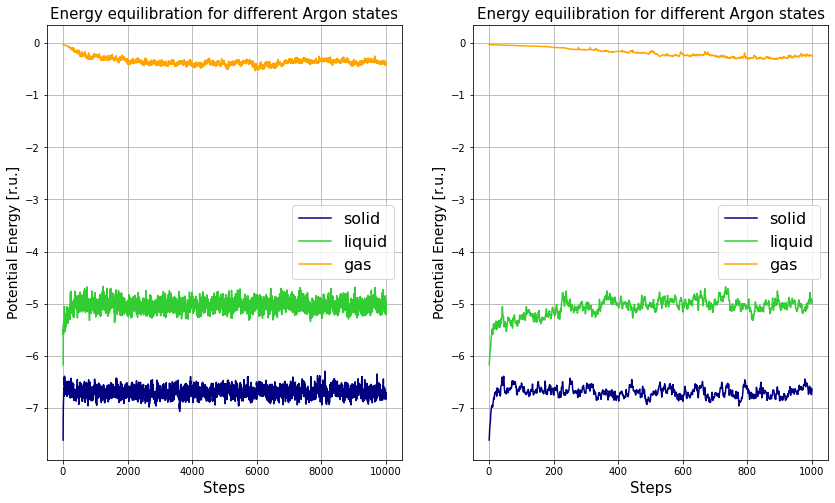

In [2]:
steps, energy_solid = np.loadtxt("equilibration_folder/solid_MC_equil.dat", unpack=True, usecols=(0,1), delimiter=",")
energy_liquid = np.loadtxt("equilibration_folder/liquid_MC_equil.dat", unpack=True, usecols=(1), delimiter=",")
energy_gas = np.loadtxt("equilibration_folder/gas_MC_equil.dat", unpack=True, usecols=(1), delimiter=",")

fig, ax  = plt.subplots(1, 2, figsize=(14 , 8))

ax[0].plot(steps, energy_solid, label="solid", color="navy")
ax[0].plot(steps, energy_liquid, label="liquid", color="limegreen")
ax[0].plot(steps, energy_gas, label="gas", color="orange")

ax[1].plot(steps[0:1000], energy_solid[0:1000], label="solid", color="navy")
ax[1].plot(steps[0:1000], energy_liquid[0:1000], label="liquid", color="limegreen")
ax[1].plot(steps[0:1000], energy_gas[0:1000], label="gas", color="orange")

for i in range(2):
    ax[i].set_title('Energy equilibration for different Argon states' , fontsize = 15)
    ax[i].set_ylabel('Potential Energy [r.u.]', fontsize = 14)
    ax[i].set_xlabel('Steps', fontsize = 15)
    ax[i].legend(loc="best", prop={'size': 16})
    ax[i].grid(True)

I grafici mostrano l'andamento dell'energia potenziale nei tre stati in cui viene simulato l'Argon (solido, liquido e gassoso).<br>L'equilibrazione viene eseguita con 4000 step per fare in modo che il sistema raggiunga lo stato gassoso disordinato. È evidente dai grafici che per la fase solida e liquida 4000 step di equilibrazione siano eccessivi dato che sono più ordinati della fase gassosa, che considero equilibrata dopo circa 2000 passi.

### Ricerca $\delta$ Metropolis per fase gassosa

In [3]:
acc_rate6 = np.loadtxt("equilibration_folder/acc_rate_gas_6.dat", unpack=True, usecols=(0))
acc_rate8 = np.loadtxt("equilibration_folder/acc_rate_gas_8.dat", unpack=True, usecols=(0))
acc_rate9 = np.loadtxt("equilibration_folder/acc_rate_gas_9.dat", unpack=True, usecols=(0))
acc_rate10 = np.loadtxt("equilibration_folder/acc_rate_gas_10.dat", unpack=True, usecols=(0))
acc_rate13 = np.loadtxt("equilibration_folder/acc_rate_gas_13.dat", unpack=True, usecols=(0))
acc_rate20 = np.loadtxt("equilibration_folder/acc_rate_gas_20.dat", unpack=True, usecols=(0))

print('δ usato:\t\t' + str(6) + '\nacceptance rate:\t' + str(np.mean(acc_rate6)) + '\n')
print('δ usato:\t\t' + str(8) + '\nacceptance rate:\t' + str(np.mean(acc_rate8)) + '\n')
print('δ usato:\t\t' + str(9) + '\nacceptance rate:\t' + str(np.mean(acc_rate9)) + '\n')
print('δ usato:\t\t' + str(10) + '\nacceptance rate:\t' + str(np.mean(acc_rate10)) + '\n')
print('δ usato:\t\t' + str(13) + '\nacceptance rate:\t' + str(np.mean(acc_rate13)) + '\n')
print('δ usato:\t\t' + str(20) + '\nacceptance rate:\t' + str(np.mean(acc_rate20)) + '\n')

δ usato:		6
acceptance rate:	0.624011573

δ usato:		8
acceptance rate:	0.6203078722500001

δ usato:		9
acceptance rate:	0.6178425959999999

δ usato:		10
acceptance rate:	0.61886574675

δ usato:		13
acceptance rate:	0.6174189867500001

δ usato:		20
acceptance rate:	0.6129884325



Riporto l'andamento dell'acceptance rate (numero di mosse accettate diviso per il numero di mosse totali proposte) in funzione del delta usato per determinare la mossa: tutte le coordinate una particella scelta a caso dall'algoritmo vengono modificate aggiungendo un numero scelto casualmente tra $[-\frac{\delta}{2};+\frac{\delta}{2}]$.

Ho riportato solo quello dello stato gassoso, l'unico dei tre che ho dovuto determinare con delle trial run. Qui l'accemptance rate rimane alto anche per alti $\delta$ perchè nel gas non c'è molta variazione di energia per lo spostamento di una molecola. In più, oltre un certo limite entrano in gioco le periodic boundary conditions, quindi aumentare ancora il $\delta$ non servirebbe allo scopo di far muovere maggiormente la molecola.

### <span style="color:cornflowerblue"> Autocorrelation <span>

In [4]:
# load data
energy_solid = np.loadtxt("correlation_folder/solid_correlation.dat", unpack=True, usecols=(1), delimiter=",")
energy_liquid = np.loadtxt("correlation_folder/liquid_correlation.dat", unpack=True, usecols=(1), delimiter=",")
energy_gas = np.loadtxt("correlation_folder/gas_correlation.dat", unpack=True, usecols=(1), delimiter=",")

In [5]:
def autocorrelation(array,size):
    autoc = np.zeros(size)
    l = array.size-size                        #!=0: size è il lag della correlazione
           
    x1 = np.mean(array[:l])                    #values until l excluded
    x1_2 = np.mean(array[:l]**2)
    sigma = x1_2 - x1**2
    
    #correlo l dati, size volte, ogni volta mi sposto di uno
    for t in range(size):
        x2 = np.mean( array[t:l+t] )           #elementi tra t e t+l
        x3 = np.mean( array[:l]*array[t:l+t] )
        
        autoc[t] = (x3 - x1*x2)/sigma
        #see lecture 5, slide 3: autocorrelation for stationary random process
    
    return autoc

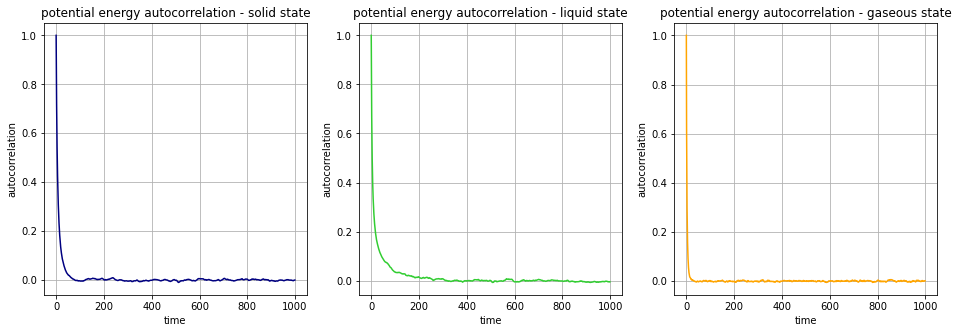

In [6]:
correlation_solid = autocorrelation(energy_solid, 1000)
correlation_liquid = autocorrelation(energy_liquid, 1000)
correlation_gas = autocorrelation(energy_gas, 1000)

fig, ax  = plt.subplots(1, 3, figsize=(16 , 5))

ax[0].plot(correlation_solid, color="navy")
ax[0].set_title("potential energy autocorrelation - solid state")

ax[1].plot(correlation_liquid, color="limegreen")
ax[1].set_title("potential energy autocorrelation - liquid state")

ax[2].plot(correlation_gas, color="orange")
ax[2].set_title("potential energy autocorrelation - gaseous state")

for i in range(3):
    ax[i].grid()
    ax[i].set_xlabel("time")
    ax[i].set_ylabel("autocorrelation")

Text(0, 0.5, 'autocorrelation')

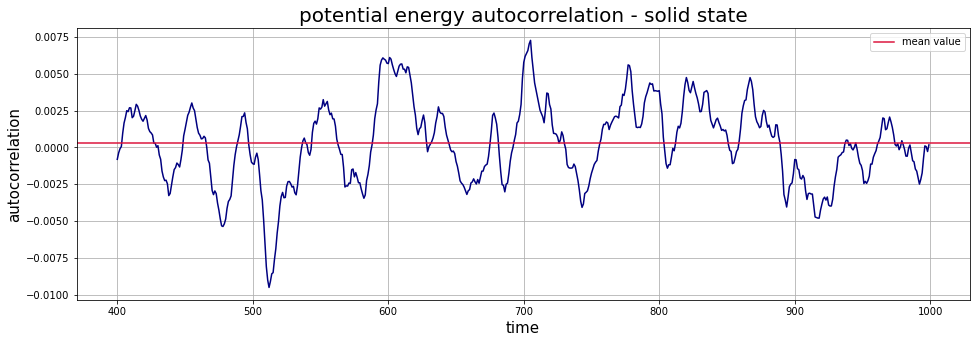

In [7]:
fig, ax  = plt.subplots(1, 1, figsize=(16 , 5))
t = np.arange(400,1000,1)
ax.plot(t, correlation_solid[400:1000], color="navy")
ax.set_title("potential energy autocorrelation - solid state", fontsize = 20)
ax.grid()
ax.axhline(np.mean(correlation_solid[400:1000]), label="mean value", color="crimson")
ax.set_xlabel("time", fontsize = 15)
ax.legend()
ax.set_ylabel("autocorrelation", fontsize = 15)

I grafici mostrano l'andamento della funzione di correlazione per l'energia potenziale del sistema nelle tre fasi e l'andamento in dettaglio per la fase solida dopo 400 step.

Come atteso, le autocorrelazioni sono significative per tempi brevi, mentre decadono all'aumentare del tempo.
La correlazione del sistema gassoso decade molto più rapidamente che negli altri casi. Questo accade perchè nello step Monte Carlo l'intervallo di campionamento della nuova posizione è molto più ampio, quindi è più facile per il sistema raggiungere nuove configurazioni.

### <span style="color:cornflowerblue"> Errors <span>

In [8]:
L = np.array([             #steps per block
    i
  for i in range(1,5001) if 50000%i == 0
])
blocchi = 5*10**5 // L[1:] #block number

In [9]:
def error (sum_prog, sum_prog2, N):
    if(N==0): return 0 
    
    var = (sum_prog2[N] - sum_prog[N]**2)/N ;
    return var**(1/2) ;


def sigma(array, blocks):
    L = int(500000/blocks)
    sum_prog = np.zeros(blocks)
    sum_prog_2 = np.zeros(blocks)
    errors = np.zeros(blocks)
    
    for i in range(blocks):
        s = 0. 
        for j in range(L):
            s += array[j + i * L] ;
        
        s /= L ;

        if (i==0):
            sum_prog[i] = s ;
            sum_prog_2[i] = s**2;

        else :
            sum_prog[i] = sum_prog[i-1] + s ;
            sum_prog_2[i] = sum_prog_2[i-1] + s**2 ;
      
    for i in range(blocks):
        sum_prog[i] /= (i+1) ;
        sum_prog_2[i] /= (i+1) ;
        errors[i] = error( sum_prog , sum_prog_2 , i );

    return errors[-1]

In [10]:
errors_solid = np.zeros(len(blocchi))
errors_liquid = np.zeros(len(blocchi))
errors_gas = np.zeros(len(blocchi))

for i in range( len(blocchi) ):
    errors_solid[i] = sigma( energy_solid, blocchi[i] )
    errors_liquid[i] = sigma( energy_liquid, blocchi[i] )
    errors_gas[i] = sigma(energy_gas, blocchi[i])

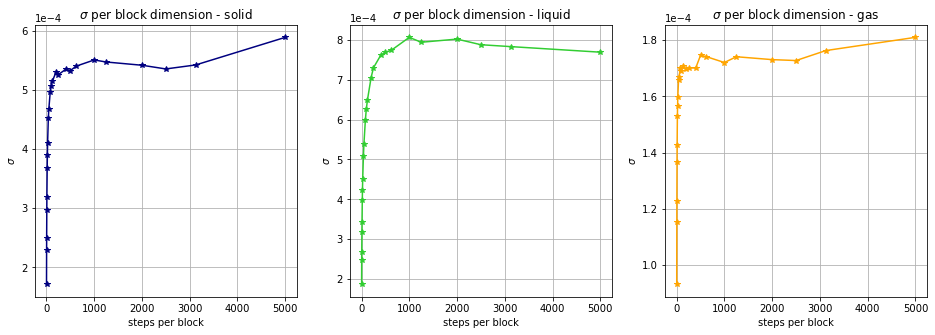

In [11]:
fig, ax  = plt.subplots(1, 3, figsize=(16 , 5))

ax[0].plot(L[1:], errors_solid, marker= "*", label = "solid state", color="navy")
ax[0].set_title(r"$\sigma$ per block dimension - solid")

ax[1].plot(L[1:], errors_liquid, marker= "*", label = "liquid state", color="limegreen")
ax[1].set_title(r"$\sigma$ per block dimension - liquid")

ax[2].plot(L[1:], errors_gas, marker= "*", label = "gaseous state", color="orange")
ax[2].set_title(r"$\sigma$ per block dimension - gas")

for i in range(3):
    ax[i].grid()
    ax[i].set_xlabel("steps per block")
    ax[i].set_ylabel(r'$ \sigma $')
    ax[i].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
#sigma = standard deviation

I grafici riportano l'andamento dell'errore sulle misure in funzione del numero di step per blocco.<br>
L'andamento è compatibile con quello atteso: in blocchi troppo piccoli le misure sono molto correlate e l'incertezza statistica viene  sottostimata. Al crescere della dimensione dei blocchi, invece, l'incertezza aumenta fino a saturare: i blocchi sono sufficientemente grandi così che le misure siano scorrelate, il valore dell'errore, quindi, non dipende dalla dimensione del blocco.

## Exercise 7.4

### <span style="color:cornflowerblue"> $g(r)$ in NVT ensemble <span>

In [12]:
g_solid_metro, error_g_solid_metro = np.loadtxt("solid/gofr_metrop.dat", delimiter=',', usecols=(0 , 1), unpack= True)
g_solid_NVE, error_g_solid_NVE = np.loadtxt("solid/gofr_NVE.dat", delimiter=',', usecols=(0 , 1), unpack= True)

g_liquid_metro, error_g_liquid_metro = np.loadtxt("liquid/gofr_metrop.dat", delimiter=',', usecols=(0 , 1), unpack= True)
g_liquid_NVE, error_g_liquid_NVE = np.loadtxt("liquid/gofr_NVE.dat", delimiter=',', usecols=(0 , 1), unpack= True)

g_gas_metro, error_g_gas_metro = np.loadtxt("gas/gofr_metrop.dat", delimiter=',', usecols=(0 , 1), unpack= True)
g_gas_NVE, error_g_gas_NVE = np.loadtxt("gas/gofr_NVE.dat", delimiter=',', usecols=(0 , 1), unpack= True)

In [13]:
#binsize = (box/2) / nbins
#box = (npart/rho)**1/3
binsize_sol = (108/1.1)**(1/3) /500.
bins_sol = np.arange( start = binsize_sol/2. , stop =  binsize_sol*(0.5 + 500), step = binsize_sol)
binsize_liq = (108/0.8)**(1/3) /500.
bins_liq = np.arange( start = binsize_liq/2. , stop =  binsize_liq*(0.5 + 500), step = binsize_liq)
binsize_gas = (108/0.05)**(1/3) /500.
bins_gas = np.linspace( start = binsize_gas/2. , stop =  binsize_gas*(0.5 + 500), num = 500)

Text(0.5, 1.0, 'Pair distribution function - gaseous state')

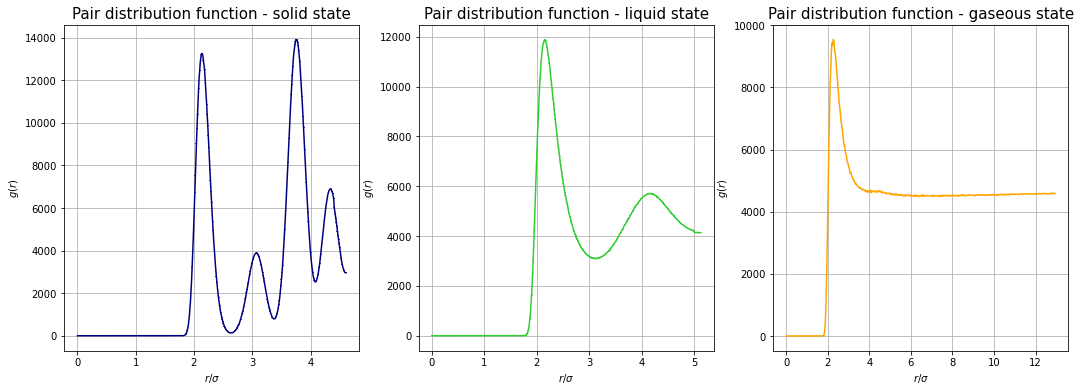

In [14]:
fig , [ax1 , ax2 , ax3] = plt.subplots( 1 , 3 , figsize = (18 , 6))
#solid
ax1.errorbar(bins_sol, g_solid_metro, yerr=error_g_solid_metro, color="navy")
ax1.set_xlabel(r'$r/ \sigma $')
ax1.set_ylabel(r'$g(r)$')
ax1.grid(True)
ax1.set_title('Pair distribution function - solid state', fontsize=15 )
#liquid
ax2.errorbar(bins_liq, g_liquid_metro, yerr=error_g_liquid_metro, color="limegreen")
ax2.set_xlabel(r'$r/ \sigma $')
ax2.set_ylabel(r'$g(r)$')
ax2.grid(True)
ax2.set_title('Pair distribution function - liquid state', fontsize=15 )
#gas
ax3.errorbar(bins_gas, g_gas_metro, yerr=error_g_gas_metro, color="orange")
ax3.set_xlabel(r'$r/ \sigma $')
ax3.set_ylabel(r'$g(r)$')
ax3.grid(True)
ax3.set_title('Pair distribution function - gaseous state', fontsize=15 )

Le funzioni di distrubuzioni a coppie raffigurate sono state ottenute evolvendo secondo un algoritmo di Metropolis. In totale ho eseguito $10^5$ step, che sono stati divisi in 20 blocchi. Ogni blocco contiene quindi 5000 step, che, per le precedenti misure di autocorrelazione, sono più che sufficienti perchè non ci sia correlazione nella misura.<br>
Con step si intende un movimento di tutte le 108 particelle: la mossa proposta viene accettata automaticamente se l'energia del sistema diminuisce, altrimenti la probabilità di accettazione è data da una distribuzione di Boltzmann.

### <span style="color:cornflowerblue"> $g(r)$ in NVE ensemble <span>

Text(0.5, 1.0, 'Pair distribution function - gaseous state')

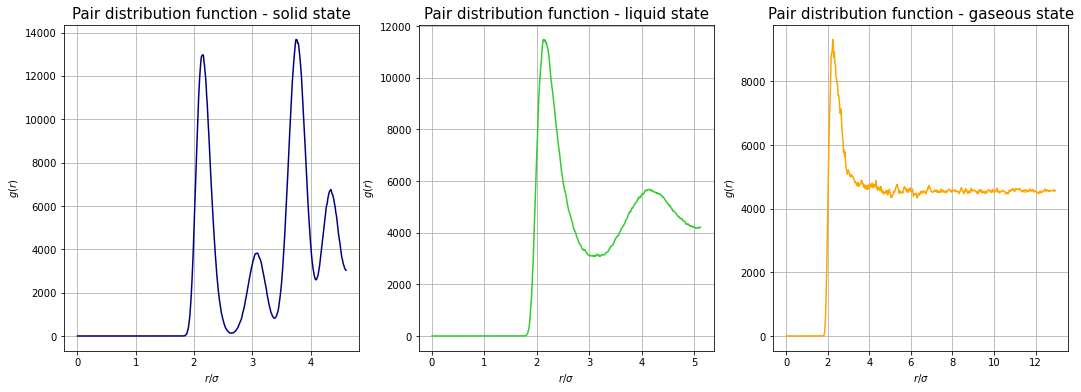

In [15]:
fig , [ax1 , ax2 , ax3] = plt.subplots( 1 , 3 , figsize = (18 , 6))
#solid
ax1.errorbar(bins_sol, g_solid_NVE, yerr=error_g_solid_NVE, color="navy")
ax1.set_xlabel(r'$r/ \sigma $')
ax1.set_ylabel(r'$g(r)$')
ax1.grid(True)
ax1.set_title('Pair distribution function - solid state', fontsize=15 )
#liquid
ax2.errorbar(bins_liq, g_liquid_NVE, yerr=error_g_liquid_NVE, color="limegreen")
ax2.set_xlabel(r'$r/ \sigma $')
ax2.set_ylabel(r'$g(r)$')
ax2.grid(True)
ax2.set_title('Pair distribution function - liquid state', fontsize=15 )
#gas
ax3.errorbar(bins_gas, g_gas_NVE, yerr=error_g_gas_NVE, color="orange")
ax3.set_xlabel(r'$r/ \sigma $')
ax3.set_ylabel(r'$g(r)$')
ax3.grid(True)
ax3.set_title('Pair distribution function - gaseous state', fontsize=15 )

Il calcolo delle funzioni di distribuzione a coppie nel codice di dinamica molecolare è stato eseguito su sistemi equilibrati. L'equilibrazione è avvenuta in maniera analoga all'esercizio 4: partendo a una temperatura diversa da quella di arrivo, il sistema evolve fino ad avere una temperatura oscillante attorno al valore voluto.

Le tre curve trovate sono plausibili, infatti:
 1. Il solido ha una struttura reticolare ordinata, infatti la funzione di distribuzione a coppie mostra il picco dei primi vicini e altri picchi regolarmente spaziati che rappresentano i vicini di ordine crescente.
 2. Il liquido ha una struttura più disordinata, rimane ben evidente il picco dei primi vicini mentre i successivi picchi sono meno intensi.
 3. Il gas invece, che presenta una fase disordinata, mostra comunque un picco di primi vicini, ma la distribuzione successivamente di appiattisce a dimostrazione della distribuzione uniforme nello spazio del gas.

### Solid state

In [16]:
iblk, energy_solid, error_energy_solid = np.loadtxt("solid/epot_metro.dat", unpack=True, usecols=(0,2,3), delimiter=",")
press_solid, error_press_solid = np.loadtxt("solid/pres_metro.dat", unpack=True, usecols=(2,3), delimiter=",")

Text(0.5, 1.0, 'Pair distribution function - solid state')

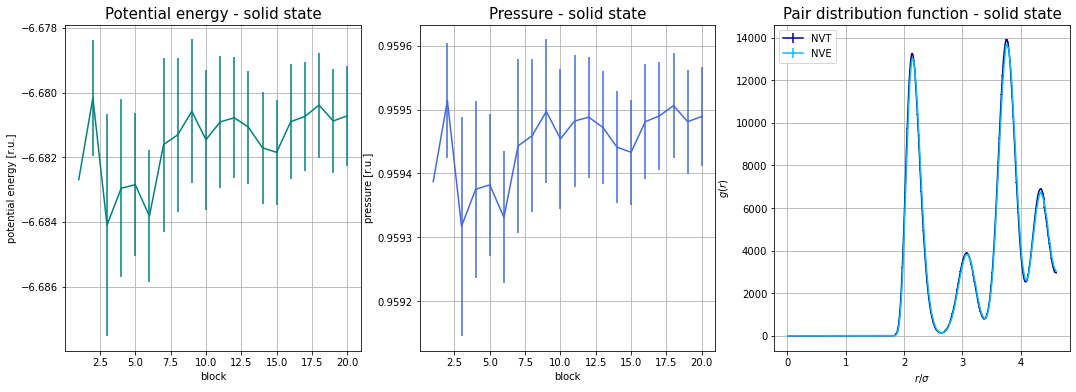

In [17]:
fig , ax = plt.subplots( 1 , 3 , figsize = (18 , 6))

ax[0].errorbar(iblk, energy_solid, yerr=error_energy_solid, color="teal")
ax[0].set_xlabel("block")
ax[0].set_ylabel("potential energy [r.u.]")
ax[0].grid(True)
ax[0].set_title('Potential energy - solid state', fontsize=15 )

ax[1].errorbar(iblk, press_solid, yerr=error_press_solid, color="royalblue")
ax[1].set_xlabel("block")
ax[1].set_ylabel("pressure [r.u.]")
ax[1].grid(True)
ax[1].set_title('Pressure - solid state', fontsize=15 )

ax[2].errorbar(bins_sol, g_solid_metro, yerr=error_g_solid_metro, color="navy", label="NVT")
ax[2].errorbar(bins_sol, g_solid_NVE, yerr=error_g_solid_NVE, color="deepskyblue", label="NVE")
ax[2].set_xlabel(r'$r/ \sigma $')
ax[2].set_ylabel(r'$g(r)$')
ax[2].legend()
ax[2].grid(True)
ax[2].set_title('Pair distribution function - solid state', fontsize=15 )

### Liquid State

In [18]:
iblk, energy_liquid, error_energy_liquid = np.loadtxt("liquid/epot_metro.dat", unpack=True, usecols=(0,2,3), delimiter=",")
press_liquid, error_press_liquid = np.loadtxt("liquid/pres_metro.dat", unpack=True, usecols=(2,3), delimiter=",")

Text(0.5, 1.0, 'Pair distribution function - liquid state')

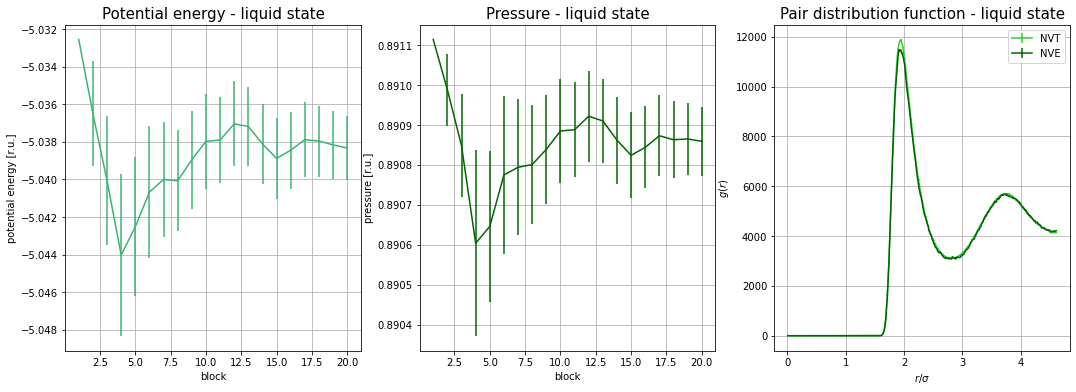

In [19]:
fig , ax = plt.subplots( 1 , 3 , figsize = (18 , 6))

ax[0].errorbar(iblk, energy_liquid, yerr=error_energy_liquid, color="mediumseagreen")
ax[0].set_xlabel("block")
ax[0].set_ylabel("potential energy [r.u.]")
ax[0].grid(True)
ax[0].set_title('Potential energy - liquid state', fontsize=15)

ax[1].errorbar(iblk, press_liquid, yerr=error_press_liquid, color="darkgreen")
ax[1].set_xlabel("block")
ax[1].set_ylabel("pressure [r.u.]")
ax[1].grid(True)
ax[1].set_title('Pressure - liquid state', fontsize=15)

ax[2].errorbar(bins_sol, g_liquid_metro, yerr=error_g_liquid_metro, color="limegreen", label="NVT")
ax[2].errorbar(bins_sol, g_liquid_NVE, yerr=error_g_liquid_NVE, color="darkgreen", label="NVE")
ax[2].set_xlabel(r'$r/ \sigma $')
ax[2].set_ylabel(r'$g(r)$')
ax[2].legend()
ax[2].grid(True)
ax[2].set_title('Pair distribution function - liquid state', fontsize=15)

### Gaseous state

In [20]:
iblk, energy_gas, error_energy_gas = np.loadtxt("gas/epot_metro.dat", unpack=True, usecols=(0,2,3), delimiter=",")
press_gas, error_press_gas = np.loadtxt("gas/pres_metro.dat", unpack=True, usecols=(2,3), delimiter=",")

Text(0.5, 1.0, 'Pair distribution function - gaseous state')

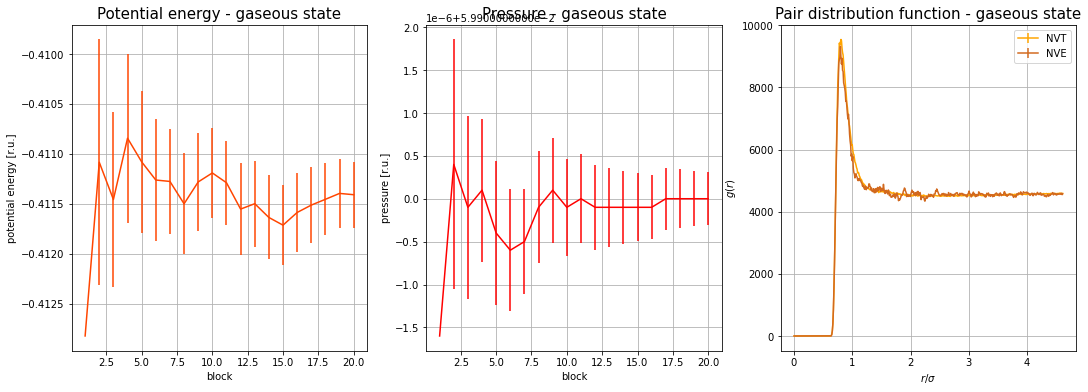

In [22]:
fig , ax = plt.subplots( 1 , 3 , figsize = (18 , 6))

ax[0].errorbar(iblk, energy_gas, yerr=error_energy_gas, color="orangered")
ax[0].set_xlabel("block")
ax[0].set_ylabel("potential energy [r.u.]")
ax[0].grid(True)
ax[0].set_title('Potential energy - gaseous state', fontsize=15)

ax[1].errorbar(iblk, press_gas, yerr=error_press_gas, color="red")
ax[1].set_xlabel("block")
ax[1].set_ylabel("pressure [r.u.]")
ax[1].grid(True)
ax[1].set_title('Pressure - gaseous state', fontsize=15)

ax[2].errorbar(bins_sol, g_gas_metro, yerr=error_g_gas_metro, color="orange", label="NVT")
ax[2].errorbar(bins_sol, g_gas_NVE, yerr=error_g_gas_NVE, color="chocolate", label="NVE")
ax[2].set_xlabel(r'$r/ \sigma $')
ax[2].set_ylabel(r'$g(r)$')
ax[2].legend()
ax[2].grid(True)
ax[2].set_title('Pair distribution function - gaseous state', fontsize=15)

Le simulazioni Monte Carlo nell'emsemble canonico sono state eseguite con un totale di $10^5$ step, suddivisi in 20 blocchi da 5000 step ciascuno. Come visto nella prima parte di questo notebook, la lunghezza dei blocchi è più che sufficiente per eliminare le correlazioni.

I risultati della pressione sono consistenti con la fisica del sistema e compatibili con i valori ottenuti nel notebook 4, dove li abbiamo calcolati nell'ensemble microcanonico. La pressione in un solido è quella più intensa, il caso intermedio è quello di un liquido e infine la pressione è minore per i gas.

Anche le energie potenziali assumono valori plausibili: l'energia risulta più intensa per il solido, che è il sistema più fortemente interagente. Il potenziale minore è calcolato nel caso del gas, che è il sistema che presenta le minori interazioni.

Il confronto tra le funzioni di distribuzione radiali mostrano un buon accordo tra i due algoritmi.

I risultati confermano che i modelli di Fisica Statistica, dove l'evoluzione delle particelle avviene in maniera casuale, ricalcano quelli in cui le particelle evolvono secondo le equazioni del moto.

## Convertire da unità ridotte a SI
Le unità ridotte sono convenienti perchè adimensionali e generiche, ovvero molte combinazioni di $\rho$, $T$, $\epsilon$ e $\sigma$ corrispondono allo stesso stato in unità ridotte (Legge degli Stati Corrispondenti). Il loro ordine di grandezza evita inoltre problemi di underflow o di overflow.

Le unità ridotte dell'Argon date le condizioni sono: 
- l'unità di lunghezza $\sigma = 0.34\:nm$;
- l'unità di energia $\frac{\epsilon}{k_B} = 120\:K$;
- l'unità di massa $m = 39.948\:amu$;

Quindi, per riconvertire da unità di Lennard Jones ad unità di misura del SI basta rimoltiplicare per le corrispettive unità, a cui aggiungiamo anche il tempo:
- lunghezza: $r = \sigma r^\star$
- temperatura: $T = \frac{\epsilon}{k_B} T^\star$
- energia: $E = \epsilon E^\star$
- tempo: $t = \sqrt{\frac{m\sigma^2}{\epsilon}} t^\star$
- pressione: $P = \frac{\sigma^3}{\epsilon}P^\star$